# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import copy
import pyranges as pr
import pandas as pd
import numpy as np
import scipy.stats
import pyreadr
import pyBigWig
import swifter
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
import matplotlib
from statannotations.Annotator import Annotator
from glob import glob
from Bio import SeqIO

In [3]:
# importing the sys module
import sys        
import os
 
project_dir = os.getcwd()[:-len("notebooks")]
sys.path.insert(0, '..')

In [4]:

from helpers.plots import MotifMetrics, LoadedMotifMetrics, MetricsHandler
from helpers.motifs import motifs

In [5]:
# paths
data_dir = project_dir + "_sdafasdfdata/"
# hackish way to use the data dir on my local machine (Lukas)
if not os.path.exists(data_dir):
    data_dir = os.path.abspath("../../test/")
results_dir = data_dir + "results/"
if not os.path.exists(results_dir):
    results_dir = os.path.join(project_dir,"results")

print("Data dir: ", data_dir)
print("Results dir: ", results_dir)


Data dir:  /home/lukas/Projects/test
Results dir:  /home/lukas/Projects/ML4RG-2023-project/results


# Aesthetics

In [21]:
#sns.set_theme(context="poster")
sns.set_theme()
#sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_context("talk", font_scale=1.7)#, rc={"font.size": 7})
#
#sns.set_context("poster", 
sns.set_style(style={'xtick.bottom': True,'ytick.left': True, 'axes.edgecolor': 'black'})
#sns.set_style("ticks")

# Evaluation in S. cerevisiae (Fig2)

In [7]:
# define paths and names of models to evaluate
model_paths = os.listdir(results_dir)
# remove the Random folder if it exists
if "random" in model_paths:
    model_paths.remove("random")
    model_paths.remove("entropy")

print(model_paths)

# work around as plots.py doesn't use os.path.join to join paths...
model_names = list(map(lambda x: os.path.basename(x), model_paths))
model_map = {"dinuc": "Dinucleotide distribution",
             "11mer": "11-mer",
             "species_aware": "Species-aware",
             "species_unaware": "Species-agnostic",
             }

model_names = list(map(lambda x: model_map[x], model_names))
model_paths = list(map(lambda x: os.path.join(results_dir, x) + "/", model_paths))

print(model_paths)
print(model_names)

# test_set 
test_path = glob(os.path.join(data_dir ,"*.fa"))[0]
print(test_path)


['dinuc', 'species_aware', 'species_unaware', '11mer']
['/home/lukas/Projects/ML4RG-2023-project/results/dinuc/', '/home/lukas/Projects/ML4RG-2023-project/results/species_aware/', '/home/lukas/Projects/ML4RG-2023-project/results/species_unaware/', '/home/lukas/Projects/ML4RG-2023-project/results/11mer/']
['Dinucleotide distribution', 'Species-aware', 'Species-agnostic', '11-mer']
/home/lukas/Projects/test/Homo_sapiens_3prime_UTR.fa


In [ ]:
print(data_dir)

In [ ]:
import pickle
print(model_paths)
motif_conservation_df = pd.read_parquet(data_dir + "/final_motif_dl_l_70.parquet")


with open(data_dir + "/final_self_df_70.pickle","rb") as f:
    mh_df = pickle.load(f)
    



In [ ]:
mh_df

In [ ]:
random_kmer_len = 5
m_start = 4955
# get only zeroth element of the tuple in every row in df['seq_range']
start_ranges = mh_df['seq_range'].apply(lambda x: x[0])  
end_ranges = mh_df['seq_range'].apply(lambda x: x[1])  

range_df = pd.DataFrame({"start": start_ranges, "end": end_ranges})

#df[df['seq_range'][0]<=m_start and m_start + random_kmer_len < df['seq_range'][1]]#.shape[0] 
range_df[(range_df['start'] <= m_start) & (m_start + random_kmer_len < range_df['end'])]# .shape[0] == 1


In [ ]:
motif_conservation_df

In [ ]:
# read fa file into pd dataframe
def read_fa(file_name):
    sequences = []
    ids = []
    species = []
    pos = []
    for s in SeqIO.parse(file_name, "fasta"):
        infos = s.id.split(":")
        ids.append(infos[0])
        species.append(infos[1])
        pos.append(infos[2])

        # exception for old file
        if len(infos) == 4:
            pos[-1] = infos[3]
        
        sequences.append(str(s.seq).upper())
    return pd.DataFrame({"seq":sequences, "id":ids, "species":species, "pos":pos})


def calculate_conservation(folder, row, id2file = None):
    position_start, position_end = row["motif_range"]
    y0, _ = row["seq_range"]

    # subtract offset which was introduced by the metrics-handler
    position_start -= y0
    position_end -= y0
    id = row["id"]
    # if id2file is None:
    #     file = glob(f"{os.path.join(folder, f'*/{id}*.fa')}")[0]
    #     df = read_fa(file)
    # else:
    df = id2file[id]

    motif_hs = df.loc[df["species"] == "Homo_sapiens"]["seq"][0][position_start:position_end]

    seqs = list(map(lambda x: x[position_start:position_end], list(df["seq"])))

    # conservation score is number of times motif_hs appears in seqs / len(seqs)
    conservation_score = seqs.count(motif_hs)/len(seqs)
    return conservation_score

In [ ]:
ranges = [0]+[x[1] for x in list(mh_df.loc[:,"seq_range"].copy())]

def get_cols_by_motif_range(row, ranges, cols, mh_df):
    x0, x1 = row.loc["motif_range"]
    x0 = int(x0)
    x1 = int(x1)
    for i in range(len(ranges)-1):
        if x1 <= ranges[i+1] and x0 >= ranges[i]:
            ret_dict = {}
            for col in cols:
                ret_dict[col] = mh_df.iloc[i][col]
            print(ret_dict)
            return ret_dict


In [ ]:

ranges = [0]+[x[1] for x in list(mh_df.loc[:,"seq_range"].copy())]

def get_conservation_score_by_motif_range(row, ranges,cols, mh_df, id2file):
    x0, x1 = row.loc["motif_range"]
    x0 = int(x0)
    x1 = int(x1)
    for i in range(len(ranges)-1):
        if x1 <= ranges[i+1] and x0 >= ranges[i]:
            ret_dict = {}
            for col in cols:
                ret_dict[col] = mh_df.iloc[i][col]
            break 
    
    position_start, position_end = row["motif_range"]
    
    id = ret_dict["id"]
    y0, _ = ret_dict["seq_range"]
    position_start -= y0
    position_end -= y0
    
    c_df = id2file[id]
    motif_hs = c_df.loc[c_df["species"] == "Homo_sapiens"]["seq"][0][position_start:position_end]

    seqs = list(map(lambda x: x[position_start:position_end], list(c_df["seq"])))
    conservation_score = seqs.count(motif_hs)/len(seqs)
    # conservation score is number of times motif_hs appears in seqs / len(seqs)
        
    ret_dict["conserv_rate"] = conservation_score
    return ret_dict

In [ ]:
ranges = [0]+[x[1] for x in list(mh_df.loc[:,"seq_range"].copy())]
import swifter
def get_col_by_motif_range(row, ranges, col, mh_df):
    x0, x1 = row.loc["motif_range"]
    x0 = int(x0)
    x1 = int(x1)
    for i in range(len(ranges)-1):
        if x1 <= ranges[i+1] and x0 >= ranges[i]:
            return mh_df.iloc[i][col]
        
            
print("adding id")
import time
start = time.time()
cols = ["id", "seq_range"]
motif_conservation_df[cols] = motif_conservation_df.swifter.apply(lambda x: get_cols_by_motif_range(x, ranges, cols, mh_df), axis=1, result_type="expand")
end = time.time()
print(f"it took: {(end-start)/60} mins")


In [ ]:
ranges = [0]+[x[1] for x in list(mh_df.loc[:,"seq_range"].copy())]
import swifter
def get_col_by_motif_range(row, ranges, col, mh_df):
    x0, x1 = row.loc["motif_range"]
    x0 = int(x0)
    x1 = int(x1)
    for i in range(len(ranges)-1):
        if x1 <= ranges[i+1] and x0 >= ranges[i]:
            return mh_df.iloc[i][col]

test_df = pd.DataFrame()    
print("adding id")
import time
start = time.time()
cols = ["id", "seq_range"]
test_df[cols] = motif_conservation_df[:3].swifter.apply(lambda x: get_cols_by_motif_range(x, ranges, cols, mh_df), axis=1, result_type="expand")
end = time.time()
print(f"it took: {(end-start)/60} mins")


In [ ]:
motif_conservation_df.to_parquet(data_dir + "/conservation_df_70.parquet")

In [8]:
motif_conservation_df = pd.read_parquet("/home/lukas/Projects/ML4RG-2023-project/notebooks/conservation_df_70.parquet")

In [9]:
motif_conservation_df

,motif_range,motif,model,avg_target_probas,alphabet_seq,shanon_entropy,id,seq_range,conserv_rate
0,"[12515548, 12515553]",non_motif,Species aware all motifs,0.315958,ACTCC,1.370951,ENST00000298542.9_utr3_11_0_chrX_132076990_r,"[12514726, 12515608]",0.132780
1,"[7290525, 7290530]",non_motif,Species aware all motifs,0.249635,ACTCC,1.370951,ENST00000374160.8_utr3_3_0_chr10_48909480_r,"[7289818, 7290575]",0.132743
2,"[10009478, 10009483]",non_motif,Species aware all motifs,0.262820,TGACT,1.921928,ENST00000397256.5_utr3_11_0_chr3_9834822_f,"[10009238, 10009818]",0.583333
3,"[7881980, 7881985]",non_motif,Species aware all motifs,0.214460,ACTCC,1.370951,ENST00000396267.3_utr3_1_0_chr17_8358822_r,"[7878900, 7889212]",0.178423
4,"[12389715, 12389720]",non_motif,Species aware all motifs,0.215341,TTCCG,1.521928,ENST00000360280.8_utr3_71_0_chr9_77416007_f,"[12388946, 12394477]",0.244813
...,...,...,...,...,...,...,...,...,...
10840718,"[13108524, 13108529]",UNK_17,Species aware all motifs,0.275231,TTAGG,1.521928,ENST00000394468.7_utr3_9_0_chr7_93188534_r,"[13108075, 13108808]",0.054167
10840719,"[13108828, 13108833]",UNK_17,Species aware all motifs,0.272801,TTAGG,1.521928,ENST00000339754.11_utr3_7_0_chr12_8096091_f,"[13108808, 13110599]",0.190871
10840720,"[13109676, 13109681]",UNK_17,Species aware all motifs,0.243267,TTAGG,1.521928,ENST00000339754.11_utr3_7_0_chr12_8096091_f,"[13108808, 13110599]",0.510373
10840721,"[13112894, 13112899]",UNK_17,Species aware all motifs,0.271611,TTAGG,1.521928,ENST00000529689.6_utr3_8_0_chr11_83259081_r,"[13111707, 13114537]",0.405286


In [ ]:
print(data_dir)

In [ ]:
id2file = {}
ids = list(motif_conservation_df["id"].unique())
folder = "../../test/3_prime_UTR/"
for id in ids:
    f = glob(os.path.join(folder, f"*/{id}*.fa"))
    if len(f) != 1:
        print(id)
        print(f)
        raise RuntimeError("Broken")
    id2file[id] = read_fa(f[0])

print("adding conservation rate")

folder = "../../test/3_prime_UTR/"
motif_conservation_df.loc[:,"conserv_rate"] = motif_conservation_df.swifter.apply(lambda x: calculate_conservation(folder, x, id2file=id2file), axis=1)
motif_conservation_df

In [ ]:
len(mh_df.id.unique())

In [ ]:
redo = False
if redo:
    id2file = {}
    ranges = [0]+[x[1] for x in list(mh_df.loc[:,"seq_range"].copy())]
    folder = "../../test/3_prime_UTR/"
    ids = list(mh_df.id.unique())
    for id in ids:
        f = glob(os.path.join(folder, f"*/{id}*.fa"))
        if len(f) != 1:
            print(id)
            print(f)
            raise RuntimeError("Broken")
        id2file[id] = read_fa(f[0])

In [ ]:

folder = "../../test/3_prime_UTR/"
cols = ["id", "seq_range"]
motif_conservation_df[["id", "seq_range", "conserv_rate"]] = motif_conservation_df.swifter.apply(lambda x: get_conservation_score_by_motif_range(x, ranges,cols, mh_df, id2file), axis=1, result_type="expand")

In [ ]:
ids = list(scer_mh.df["id"])
ids = list(map(lambda x: x.split("_")[4], ids))
print(set(ids))

In [13]:
motif_conservation_df

,motif_range,motif,model,avg_target_probas,alphabet_seq,shanon_entropy,id,seq_range,conserv_rate
0,"[12515548, 12515553]",non_motif,Species aware all motifs,0.315958,ACTCC,1.370951,ENST00000298542.9_utr3_11_0_chrX_132076990_r,"[12514726, 12515608]",0.132780
1,"[7290525, 7290530]",non_motif,Species aware all motifs,0.249635,ACTCC,1.370951,ENST00000374160.8_utr3_3_0_chr10_48909480_r,"[7289818, 7290575]",0.132743
2,"[10009478, 10009483]",non_motif,Species aware all motifs,0.262820,TGACT,1.921928,ENST00000397256.5_utr3_11_0_chr3_9834822_f,"[10009238, 10009818]",0.583333
3,"[7881980, 7881985]",non_motif,Species aware all motifs,0.214460,ACTCC,1.370951,ENST00000396267.3_utr3_1_0_chr17_8358822_r,"[7878900, 7889212]",0.178423
4,"[12389715, 12389720]",non_motif,Species aware all motifs,0.215341,TTCCG,1.521928,ENST00000360280.8_utr3_71_0_chr9_77416007_f,"[12388946, 12394477]",0.244813
...,...,...,...,...,...,...,...,...,...
10840718,"[13108524, 13108529]",UNK_17,Species aware all motifs,0.275231,TTAGG,1.521928,ENST00000394468.7_utr3_9_0_chr7_93188534_r,"[13108075, 13108808]",0.054167
10840719,"[13108828, 13108833]",UNK_17,Species aware all motifs,0.272801,TTAGG,1.521928,ENST00000339754.11_utr3_7_0_chr12_8096091_f,"[13108808, 13110599]",0.190871
10840720,"[13109676, 13109681]",UNK_17,Species aware all motifs,0.243267,TTAGG,1.521928,ENST00000339754.11_utr3_7_0_chr12_8096091_f,"[13108808, 13110599]",0.510373
10840721,"[13112894, 13112899]",UNK_17,Species aware all motifs,0.271611,TTAGG,1.521928,ENST00000529689.6_utr3_8_0_chr11_83259081_r,"[13111707, 13114537]",0.405286


In [ ]:
motif_conservation_df.columns

In [1]:
test = motif_conservation_df.groupby("alphabet_seq")[["shanon_entropy","conserv_rate","avg_target_probas"]].mean().sort_values(by=["conserv_rate"], ascending=False)

NameError: name 'motif_conservation_df' is not defined

In [15]:
test

,shanon_entropy,conserv_rate,avg_target_probas
alphabet_seq,,,
ACTTA,1.521928,0.409550,0.245231
ACGCG,1.521928,0.395775,0.211695
TCCGG,1.521928,0.388860,0.233067
GGTCG,1.370951,0.385963,0.228689
GCGTA,1.921928,0.385286,0.177037
...,...,...,...
TTGGG,0.970951,0.359689,0.330296
GCGCG,0.970951,0.359494,0.359471
ACTCC,1.370951,0.359244,0.426455


<Figure size 2000x500 with 0 Axes>

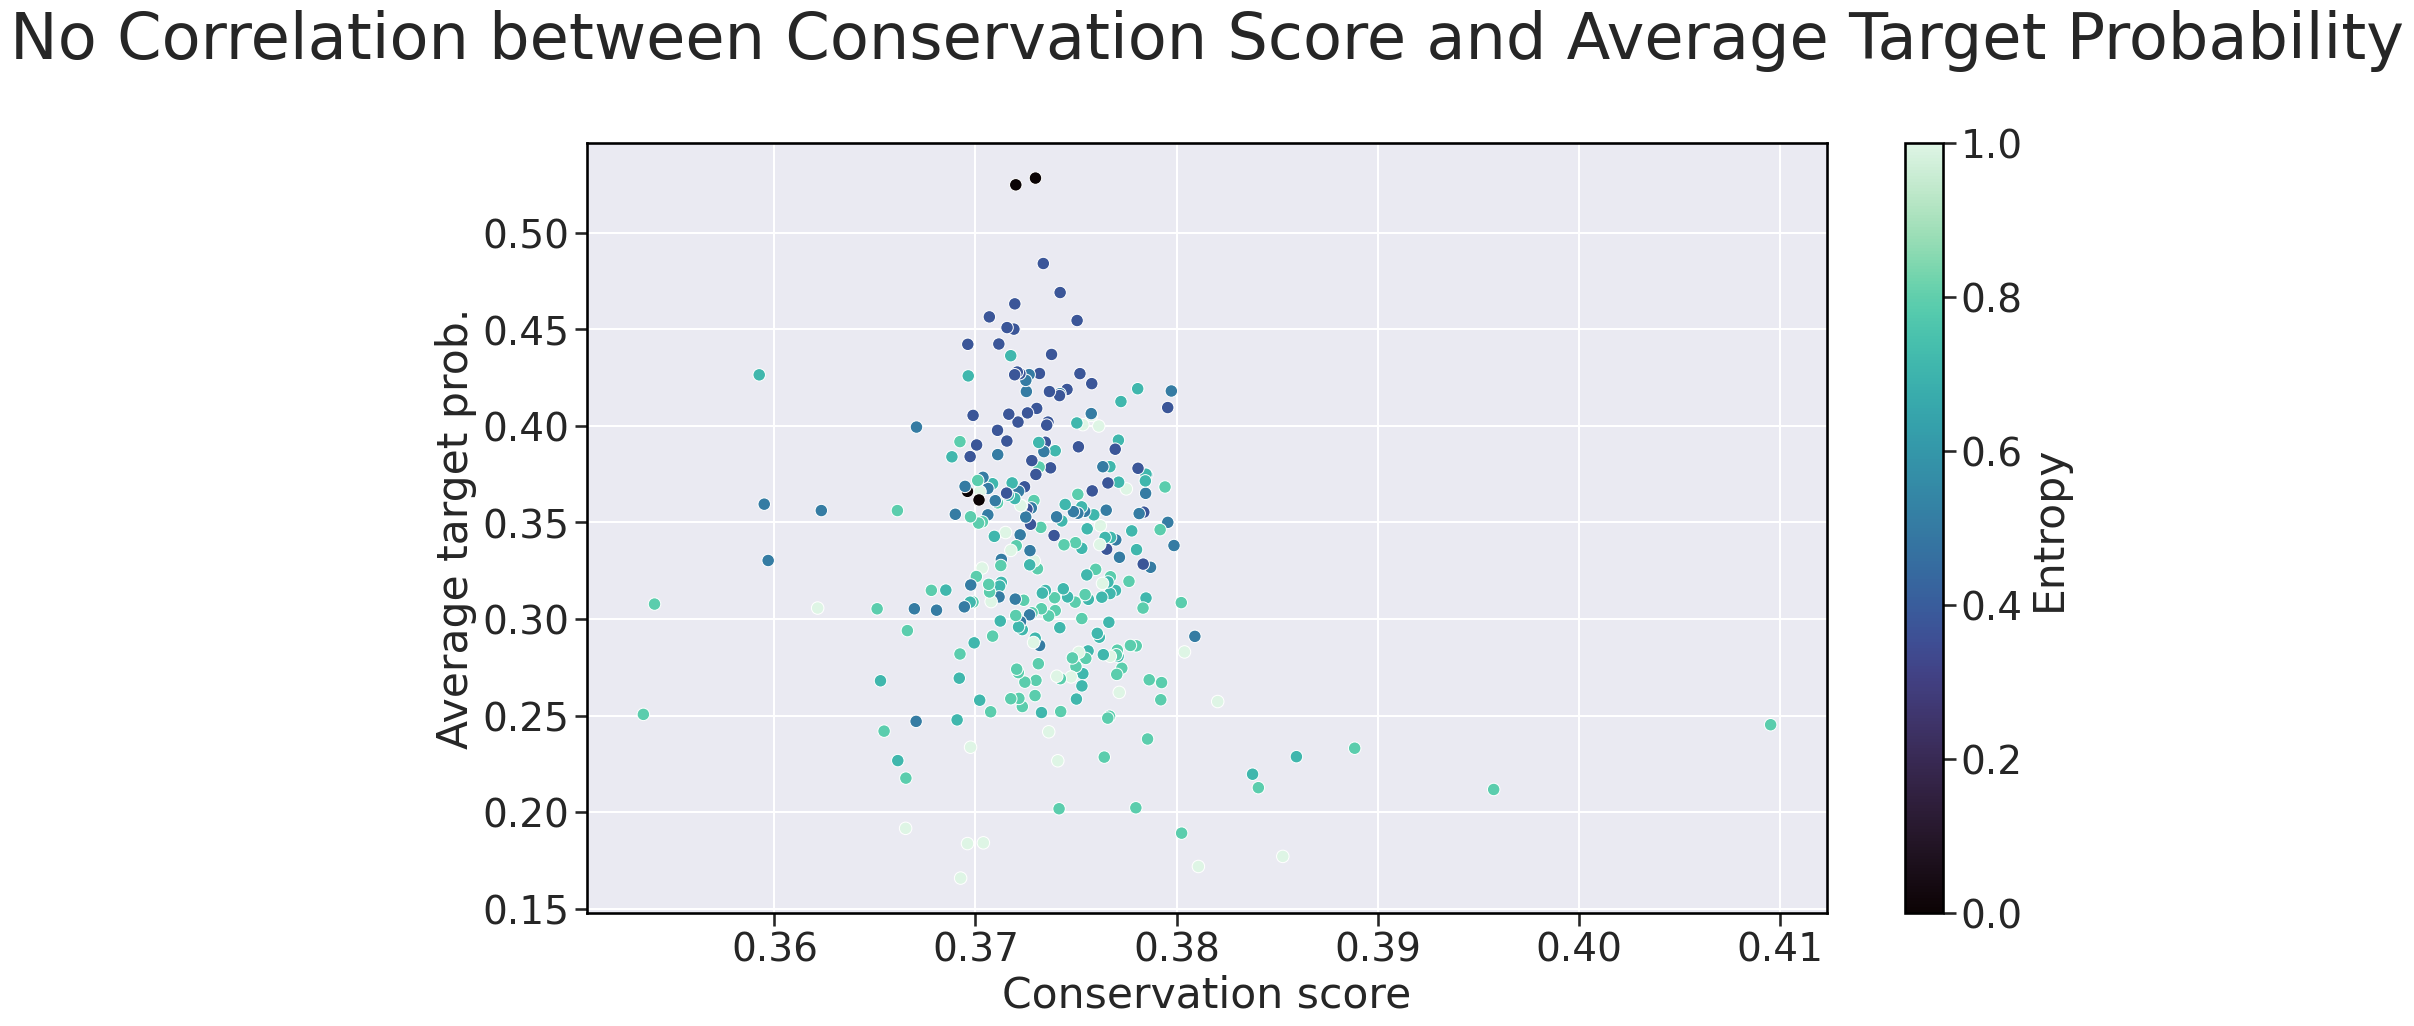

In [115]:
plt.clf()
fig, ax = plt.subplots(figsize=(20,10))
# make scatterplot dots smaller

ax = sns.scatterplot(data = test, x="conserv_rate", y="avg_target_probas", hue="shanon_entropy",palette="mako")
sm = plt.cm.ScalarMappable(cmap="mako")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("No Correlation between Conservation Score and Average Target Probability\n", fontsize=46)
ax.set_xlabel("Conservation score")
ax.set_ylabel("Average target prob.")
ax.get_legend().remove()
cb = ax.figure.colorbar(sm, ax=ax)
cb.set_label('Entropy')
plt.show()

# todo add color for entropy

In [35]:
# get all rows where the conseravtion score is bigger than 0.385 or smaller than 0.355
outlier_motifs = list(test[test["conserv_rate"] > 0.385].index)
# find all rows where alphabet_seq is in outlier_motifs
outlier_motifs_df = motif_conservation_df.loc[motif_conservation_df["alphabet_seq"].isin(outlier_motifs)]

In [36]:
print(outlier_motifs)
proteins = list(outlier_motifs_df["motif"].unique())
# remove non_motif from proteins
proteins.remove("non_motif")

['ACTTA', 'ACGCG', 'TCCGG', 'GGTCG', 'GCGTA']


In [37]:
proteins
# from outlier_motifs_df, get all rows where motif is in proteins
outlier_motifs_df = outlier_motifs_df.loc[outlier_motifs_df["motif"].isin(proteins)]
outlier_motifs_df[["motif", "alphabet_seq"]].drop_duplicates().reset_index(drop=True)

,motif,alphabet_seq
0,RBM22_3,TCCGG
1,RBM4_4,GCGTA
2,EIF4G2_5,GGTCG
3,RBM4B_10,ACGCG
4,RBM45_13,ACGCG


<Figure size 2000x500 with 0 Axes>

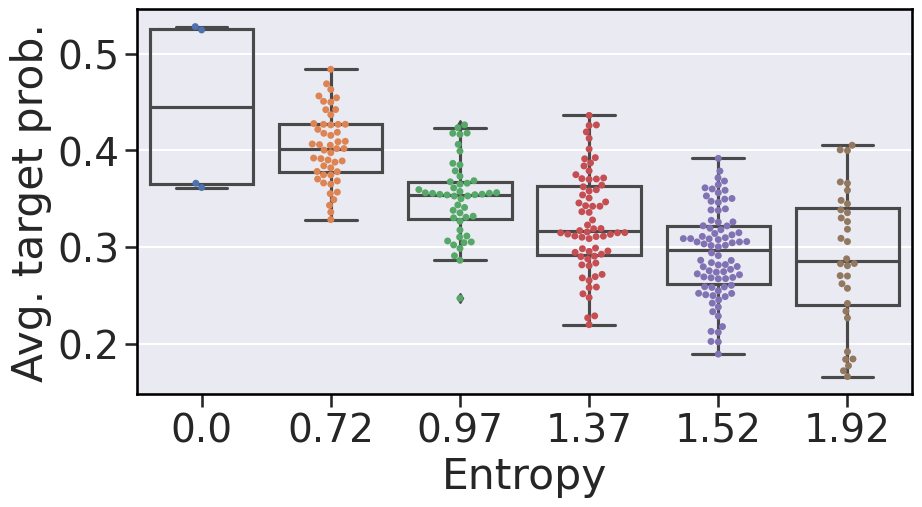

In [109]:
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.swarmplot(x=test["shanon_entropy"].round(2), y=test["avg_target_probas"])
ax = sns.boxplot(x=test["shanon_entropy"].round(2), y=test["avg_target_probas"],boxprops={'facecolor':'None'})
#ax.grid()
#ax.set_title("Average Target Probabilty Decreases With Increasing Entropy\n")
ax.set_xlabel("Entropy")
ax.set_ylabel("Avg. target prob.")
plt.show()

In [39]:
all_motifs = list(motif_conservation_df["motif"].unique())
all_motifs.remove("non_motif")

In [145]:
motif_conservation_df
#TODO for best motifs + 5 random add plot for toprow motif avg target prob against conserv rate

,motif_range,motif,model,avg_target_probas,alphabet_seq,shanon_entropy,id,seq_range,conserv_rate
0,"[12515548, 12515553]",non_motif,Species aware all motifs,0.315958,ACTCC,1.370951,ENST00000298542.9_utr3_11_0_chrX_132076990_r,"(12514726, 12515608)",0.132780
1,"[7290525, 7290530]",non_motif,Species aware all motifs,0.249635,ACTCC,1.370951,ENST00000374160.8_utr3_3_0_chr10_48909480_r,"(7289818, 7290575)",0.132743
2,"[10009478, 10009483]",non_motif,Species aware all motifs,0.262820,TGACT,1.921928,ENST00000397256.5_utr3_11_0_chr3_9834822_f,"(10009238, 10009818)",0.583333
3,"[7881980, 7881985]",non_motif,Species aware all motifs,0.214460,ACTCC,1.370951,ENST00000396267.3_utr3_1_0_chr17_8358822_r,"(7878900, 7889212)",0.178423
4,"[12389715, 12389720]",non_motif,Species aware all motifs,0.215341,TTCCG,1.521928,ENST00000360280.8_utr3_71_0_chr9_77416007_f,"(12388946, 12394477)",0.244813
...,...,...,...,...,...,...,...,...,...
10840718,"[13108524, 13108529]",UNK_17,Species aware all motifs,0.275231,TTAGG,1.521928,ENST00000394468.7_utr3_9_0_chr7_93188534_r,"(13108075, 13108808)",0.054167
10840719,"[13108828, 13108833]",UNK_17,Species aware all motifs,0.272801,TTAGG,1.521928,ENST00000339754.11_utr3_7_0_chr12_8096091_f,"(13108808, 13110599)",0.190871
10840720,"[13109676, 13109681]",UNK_17,Species aware all motifs,0.243267,TTAGG,1.521928,ENST00000339754.11_utr3_7_0_chr12_8096091_f,"(13108808, 13110599)",0.510373
10840721,"[13112894, 13112899]",UNK_17,Species aware all motifs,0.271611,TTAGG,1.521928,ENST00000529689.6_utr3_8_0_chr11_83259081_r,"(13111707, 13114537)",0.405286


In [127]:
motif_to_seq = motif_conservation_df[["motif","alphabet_seq"]].drop_duplicates()

In [133]:
motif_to_seq = motif_to_seq.drop_duplicates()

In [135]:
motif_to_seq = motif_to_seq[motif_to_seq["motif"] != "non_motif"]

In [143]:
motif2seq = motif_to_seq.set_index("motif",drop=True).to_dict()["alphabet_seq"]


In [40]:
print(all_motifs)
nums = sorted(list(set(map(lambda x: int(x.split("_")[-1]), all_motifs))))

top_k = 1
nums = nums[:top_k]
# find all motifs which end with "_num" where num is from nums
top_k_motifs = list(filter(lambda x: int(x.split("_")[-1]) in nums, all_motifs))
# group top_k_motifs by string before _num
top_k_dict = {}
for motif in top_k_motifs:
    mot = "".join(motif.split("_")[:-1])
    #print(mot)
    if motif.split("_")[0] not in top_k_dict:
        top_k_dict[mot] = [motif]
    else:
        top_k_dict[mot].append(motif)
print(top_k_dict)

print(len(top_k_dict.keys()))


['BOLL_2', 'CELF1_2', 'CNOT4_2', 'CPEB1_2', 'DAZ3_2', 'DAZAP1_2', 'EIF4G2_2', 'ELAVL4_2', 'ESRP1_2', 'EWSR1_2', 'FUBP1_2', 'FUBP3_2', 'FUS_2', 'HNRNPA0_2', 'HNRNPA2B1_2', 'HNRNPC_2', 'HNRNPCL1_2', 'HNRNPD_2', 'HNRNPDL_2', 'HNRNPF_2', 'HNRNPH2_2', 'HNRNPK_2', 'HNRNPL_2', 'IGF2BP1_2', 'IGF2BP2_2', 'ILF2_2', 'KHDRBS2_2', 'KHDRBS3_2', 'KHSRP_2', 'MBNL1_2', 'MSI1_2', 'NOVA1_2', 'NUPL2_2', 'PABPN1L_2', 'PCBP1_2', 'PCBP2_2', 'PCBP4_2', 'PRR3_2', 'PTBP3_2', 'PUF60_2', 'PUM1_2', 'RALY_2', 'RBFOX2_2', 'RBFOX3_2', 'RBM15B_2', 'RBM22_2', 'RBM23_2', 'RBM24_2', 'RBM25_2', 'RBM4_2', 'RBM41_2', 'RBM45_2', 'RBM47_2', 'RBM4B_2', 'RBM6_2', 'RBMS2_2', 'RBMS3_2', 'RC3H1_2', 'SF1_2', 'SFPQ_2', 'SNRPA_2', 'SRSF10_2', 'SRSF11_2', 'SRSF2_2', 'SRSF4_2', 'SRSF5_2', 'SRSF8_2', 'SRSF9_2', 'TAF15_2', 'TARDBP_2', 'TIA1_2', 'TRA2A_2', 'TRNAU1AP_2', 'UNK_2', 'ZCRB1_2', 'ZFP36_2', 'ZNF326_2', 'A1CF_3', 'BOLL_3', 'CELF1_3', 'CNOT4_3', 'CPEB1_3', 'DAZ3_3', 'DAZAP1_3', 'EIF4G2_3', 'ELAVL4_3', 'ESRP1_3', 'EWSR1_3', 'FUBP1_

PABPN1L
['PABPN1L_2']
['PABPN1L_2']


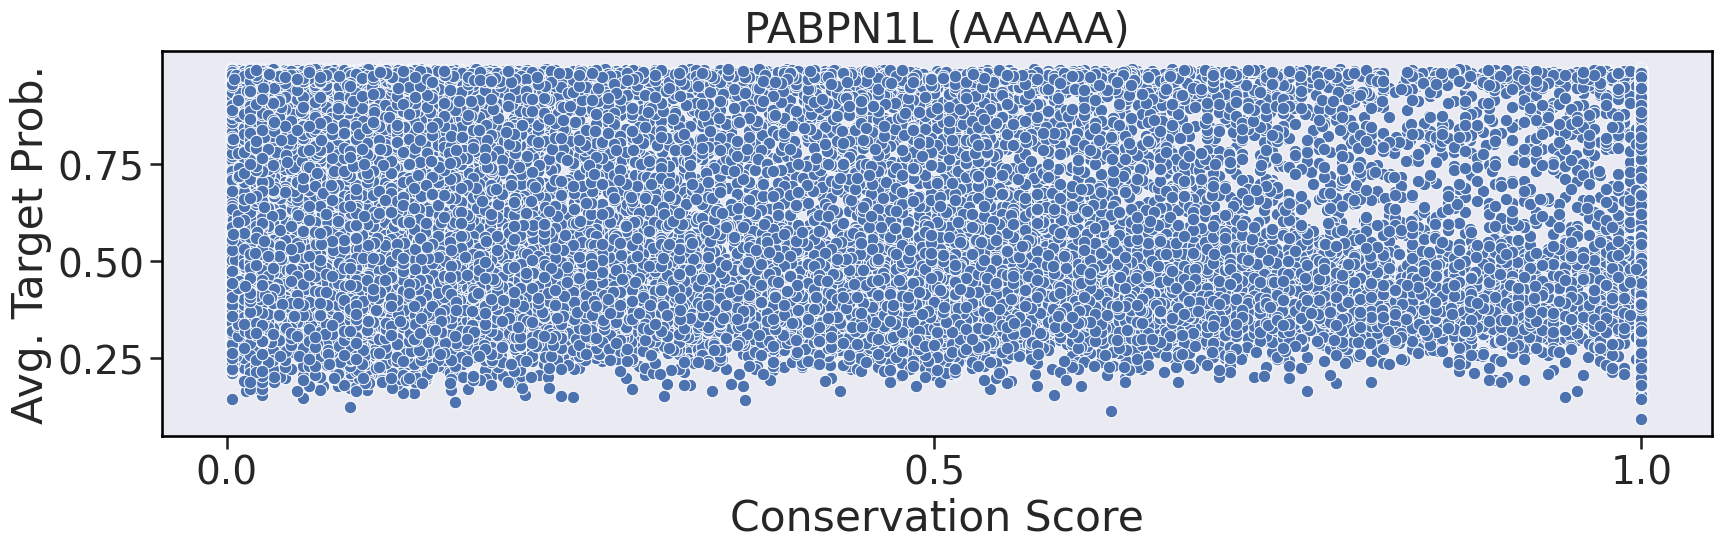

HNRNPC
['HNRNPC_2']
['HNRNPC_2']


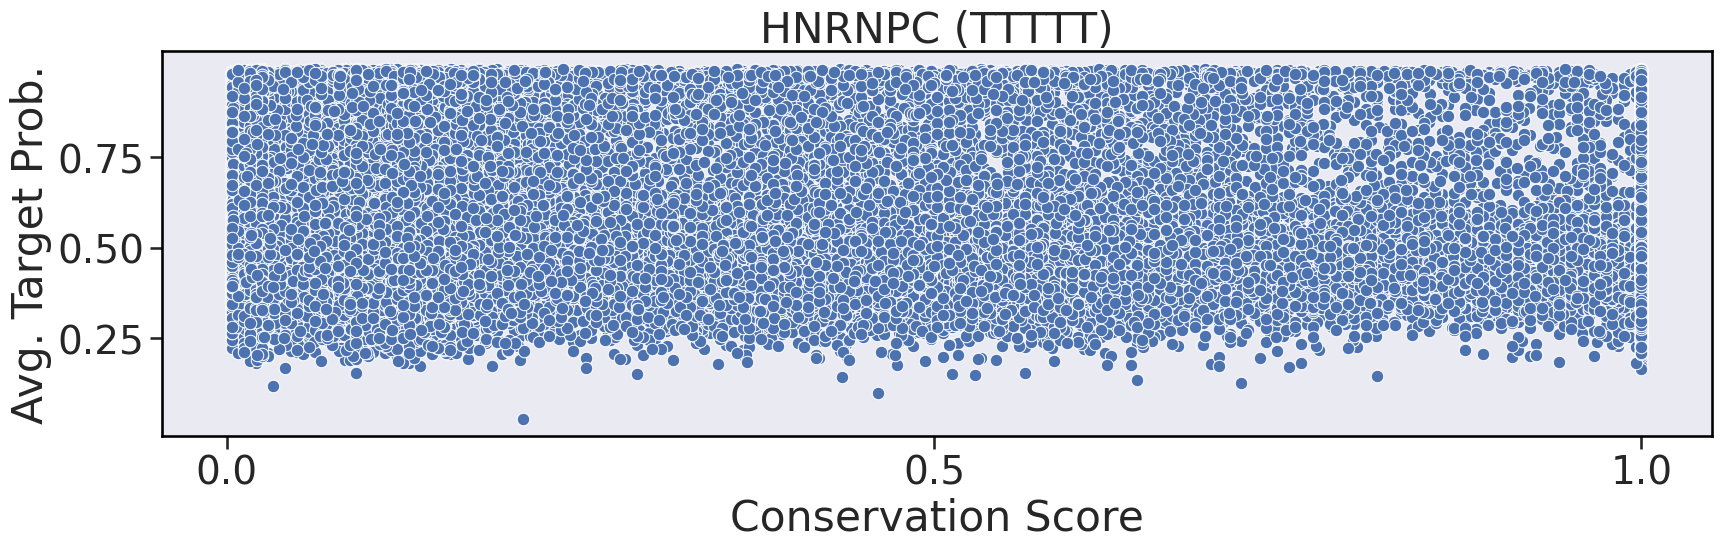

TIA1
['TIA1_2']
['TIA1_2']


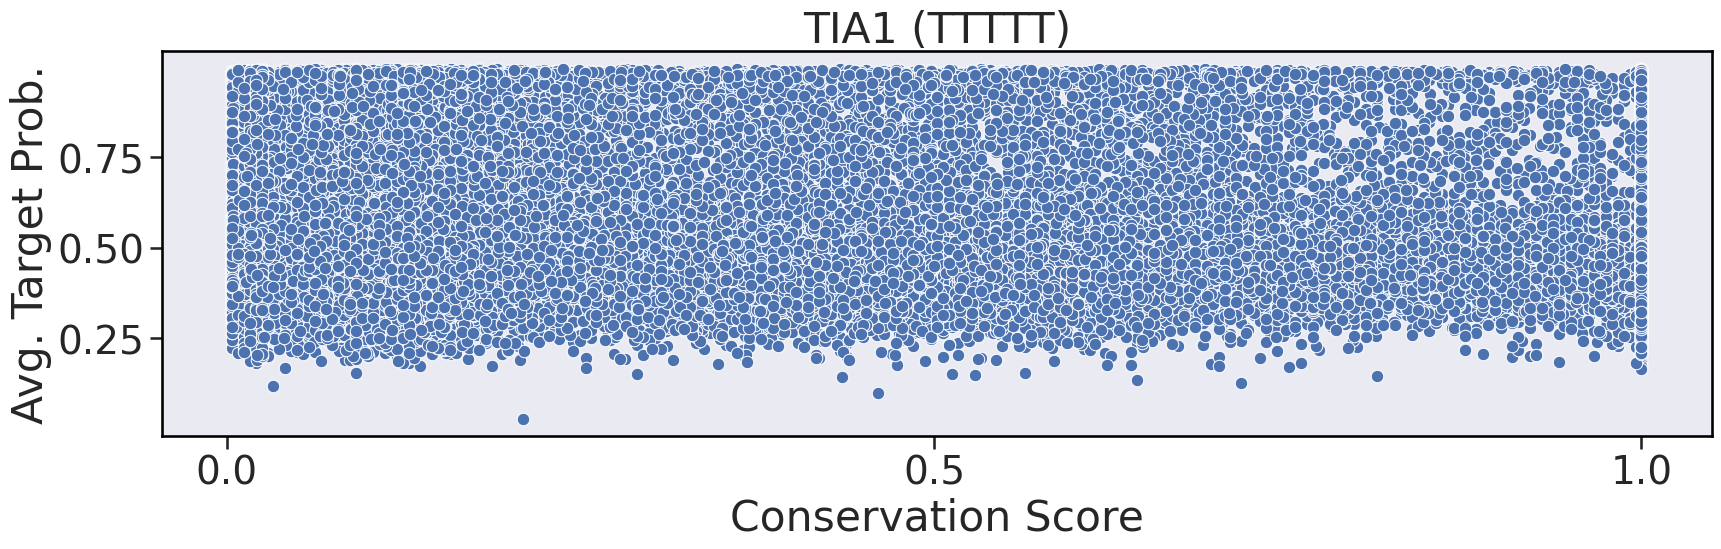

In [173]:
i = 0
#for motif in top_k_dict:
#for motif in ["TARDBP", "RBFOX2", "CELF1"]:
for motif in ["PABPN1L", "HNRNPC", "TIA1"]:
    print(motif) 
    print(top_k_dict[motif])
    print(top_k_dict[motif])
    top_k_motifs_df = motif_conservation_df.loc[motif_conservation_df["motif"].isin(top_k_dict[motif])]
    top_k_motifs_df = top_k_motifs_df[["conserv_rate","avg_target_probas"]].reset_index()
    plt.clf()
    sns.scatterplot(data=top_k_motifs_df, x="conserv_rate", y="avg_target_probas")
    plt.title(f"{motif} ({motif2seq[top_k_dict[motif][0]]})")
    plt.xlabel('Conservation Score')
    plt.ylabel('Avg. Target Prob.')
    plt.yticks([0.25, 0.5, 0.75])
    plt.xticks([0,0.5,1])
    plt.grid()
    plt.show()
    if i == 4:
        break
    i+=1

BOLL
['BOLL_2']


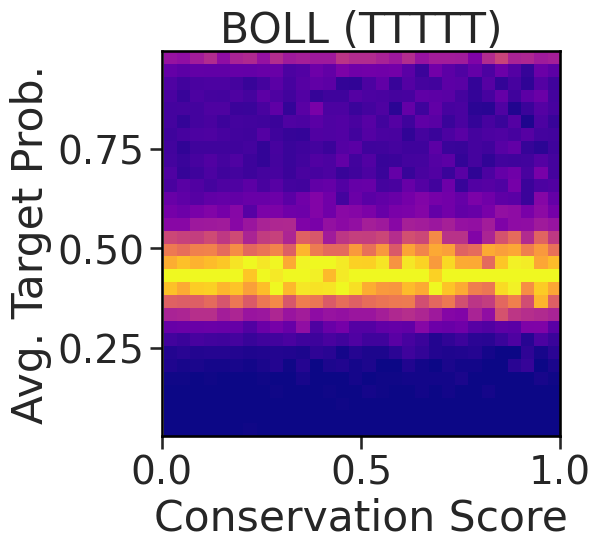

CELF1
['CELF1_2']


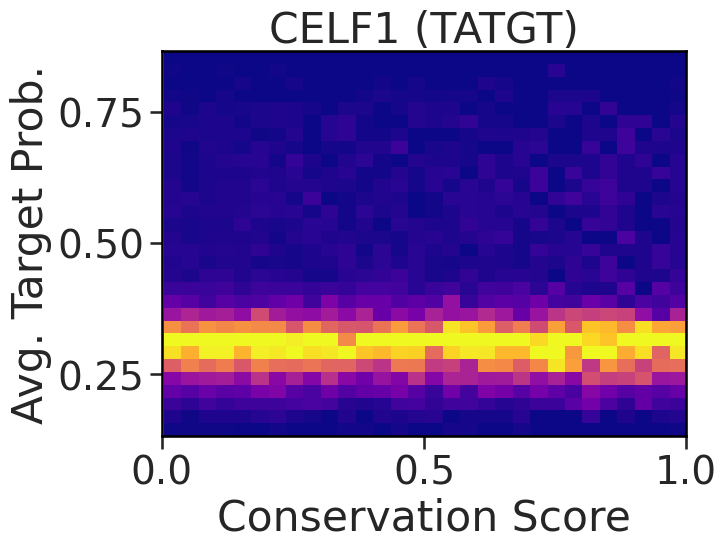

CNOT4
['CNOT4_2']


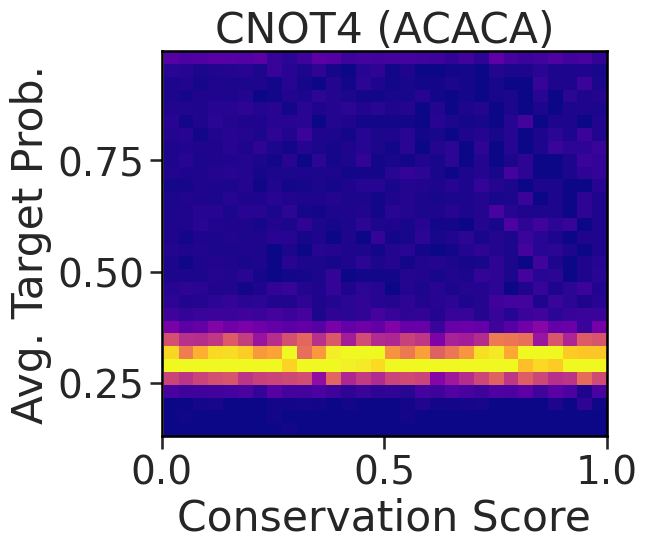

CPEB1
['CPEB1_2']


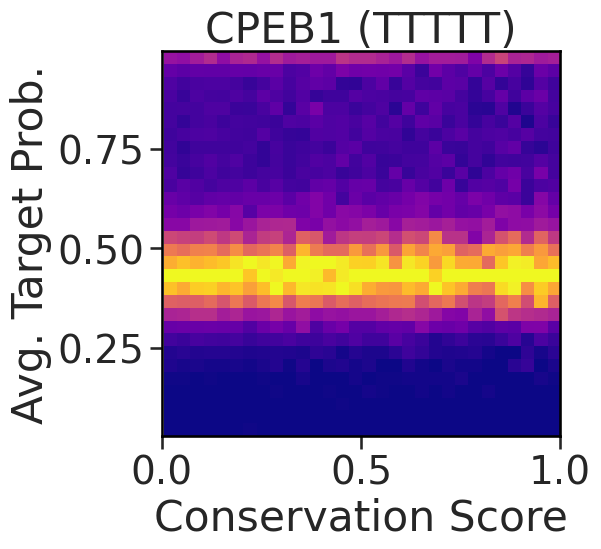

DAZ3
['DAZ3_2']


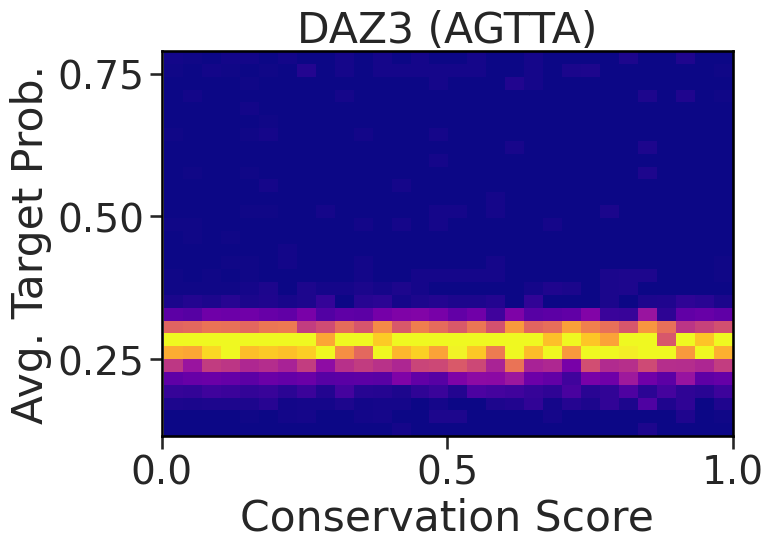

DAZAP1
['DAZAP1_2']


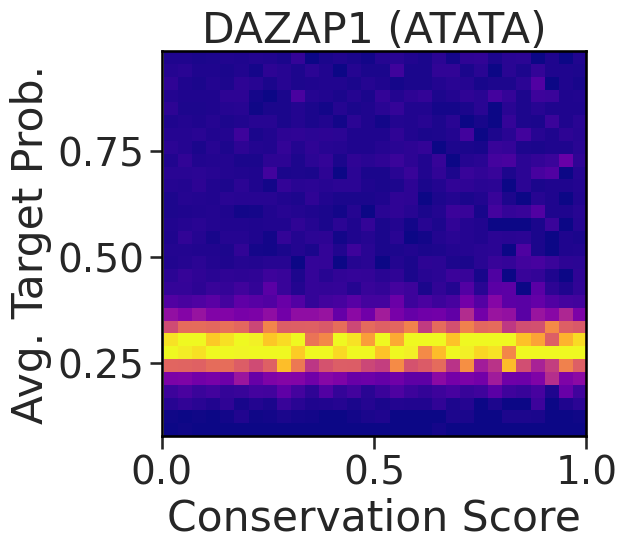

In [167]:
i = 0

import matplotlib
import sklearn
plt.clf()
plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})
for motif in top_k_dict:
#for motif in ["TARDBP", "RBFOX2", "CELF1"]:
#for motif in ["PABPN1L", "HNRNPC", "TIA1"]:
    print(motif)
    print(top_k_dict[motif])
    # get lines where top_k_dict[motif] is in motif_conservation_df["motif"]
    top_k_motifs_df = motif_conservation_df.loc[motif_conservation_df["motif"].isin(top_k_dict[motif])]
    top_k_motifs_df = top_k_motifs_df[["conserv_rate","avg_target_probas"]].reset_index()

    plt.clf()
    scaler = sklearn.preprocessing.MinMaxScaler()
    x = top_k_motifs_df["conserv_rate"].to_numpy()
    y = top_k_motifs_df["avg_target_probas"].to_numpy()
    hist, xedges, yedges = np.histogram2d(x, y, bins=30)
    hist = scaler.fit_transform(hist.T)
    plt.grid()
    plt.imshow(hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='plasma')
    
    #plt.colorbar()
    plt.title(f"{motif} ({motif2seq[top_k_dict[motif][0]]})")
    plt.xlabel('Conservation Score')
    plt.ylabel('Avg. Target Prob.')
    plt.yticks([0.25, 0.5, 0.75])
    plt.xticks([0,0.5,1])
    plt.show()

    # plt.clf()
    # fig, ax = plt.subplots(figsize=(20,5))
    # ax = sns.histplot(top_k_motifs_df, x="conserv_rate", y="avg_target_probas", binks=10)
    # # change size of figure
    # #reset rcParams
    # ax.set_title(motif)
    # ax.set_xlabel("Conservtation score")
    # ax.set_ylabel("Average target prob.")
    #plt.show()
    if i == 5:
        break
    i += 1
    


In [ ]:
motif_conservation_df.to_parquet("conservation_df_70.parquet")

In [ ]:
folder = "../../test/3_prime_UTR/"
chrs_in_folder = list(map(lambda x: os.path.basename(x), glob(os.path.join(folder, "*/*.fa"))))

chrs_in_folder = list(map(lambda x: x.split("_")[4], chrs_in_folder))
print(set(chrs_in_folder))

In [ ]:
a = set()
for id in id2file.keys():
    chr = id.split("_")[4]
    a.add(chr)

print(a)

In [ ]:
# test if it is correct
def test_col_get():
    motifs_df = motifs.df

    for _, r in motif_conservation_df.iterrows():
        motif_name = r["motif"]
        if motif_name == "non_motif":
            continue
        x0, x1 = r["motif_range"]
        y0, _ = r["seq_range"]
        seq = r["seq"]

        motif_in_seq = seq[x0- y0 : x1-y0]

        should_be = motifs_df[motifs_df["name"]== motif_name]["seq"].iloc[0]
        if should_be != motif_in_seq:
            raise RuntimeError("Broken....")

    print("Test passed.")
test_col_get()

In [ ]:
# add motif sequence to motif_conservation_df
def add_motif_seq(row):
    x0, x1 = row["motif_range"]
    y0, _ = row["seq_range"]
    seq = row["seq"]
    motif_in_seq = seq[x0- y0 : x1-y0]
    return motif_in_seq

motif_conservation_df.loc[:,"motif_seq"] = motif_conservation_df.apply(add_motif_seq, axis=1)


In [ ]:
motif_conservation_df

In [ ]:
# plot motif against average conservation score
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.boxplot(data=motif_conservation_df, x='motif', y='conserv_rate')

In [ ]:
# point scatterplot of x=conserv_rate and y=avg_target_probas
# subplot by motif 
for motif in motif_conservation_df["motif"].unique():
    print(motif)
    plt.clf()
    plt.figure(figsize=(10,5))
    plt.title(f"Motif: {motif}", fontsize=15)
    df = motif_conservation_df[motif_conservation_df["motif"] == motif]
    sns.scatterplot(data=df, x="conserv_rate", y="avg_target_probas")
    # add al inear regression line
    sns.lmplot(data=df, x="conserv_rate", y="avg_target_probas", fit_reg=False)
    plt.lmplot(data=df, x="conserv_rate", y="avg_target_probas", fit_reg=False)
    plt.xticks(size=12)
    plt.xlabel('conserv_rate', fontsize=12)
    plt.yticks(size=12)
    plt.ylabel('avg_target_probas', fontsize=12)
    plt.show()

# TODO plot average conserv_score against average target probas

In [ ]:
# point scatterplot of x=conserv_rate and y=avg_target_probas
# subplot by motif 
motif_conservation_df["chr"] = motif_conservation_df.apply(lambda x: x["id"].split("_")[4], axis=1)
print(motif_conservation_df["chr"].unique())
for chr in motif_conservation_df["chr"].unique():
    df = motif_conservation_df[motif_conservation_df["chr"] == chr]
    plt.clf()
    plt.figure(figsize=(10,5))
    plt.title(f"chr: {chr}", fontsize=15)
    sns.regplot(data=df, x="conserv_rate", y="avg_target_probas", line_kws = {"color": "red"})
    plt.xticks(size=12)
    plt.xlabel('conserv_rate', fontsize=12)
    plt.yticks(size=12)
    plt.ylabel('avg_target_probas', fontsize=12)
    plt.show()

In [ ]:
folder = "../../test/3_prime_UTR/"
motif_conservation_df.loc[:,"conserv_rate"] = motif_conservation_df.apply(lambda x: calculate_conservation(folder, x, id2file=id2file), axis=1)
motif_conservation_df

In [ ]:
motif_conservation_df[motif_conservation_df['conserv_rate'] == None]

In [ ]:
# print histogram of conservation rates
motif_conservation_df["conserv_rate"].hist(bins=50)

In [ ]:
conservation_rate_file = "motif_conservation_df.pickle"

with open(conservation_rate_file, "wb") as f:
    pickle.dump(motif_conservation_df, f)

In [ ]:
# motif renaming
def motif_correction(m_name):
    return m_name +"\n"+ motifs.name_seq_dict[m_name].replace("T","U")
def fix(x):
    if x=="non_motif":
        return "non-motif"
    else:
        return motif_correction(x)

In [ ]:


# adding gpar positions here

cols = ["motif_range","motif","model","avg_target_probas"]
keep_models = ["Dinucleotide distribution","Dinuc_test", "11-mer", "Species-aware", "Species-unaware"]

scer_df_gpar = scer_mh.motif_df_l[scer_mh.motif_df_l["model"].isin(keep_models)]

#scer_test_path_gpar = data_dir + "gpar_clip_jun.csv"

#scer_mh_gpar = MetricsHandler(model_paths, _names, scer_test_path_gpar, motifs=motifs, seq_col="UTR3_seq",
                         #binding_site_col="gpar_binding", random_kmer_len=7, n_random_kmers=6290, existing_probas=[False, False,True, False,False,])

#gpar_plot_df = scer_mh_gpar.motif_df_l
#gpar_plot_df = gpar_plot_df[gpar_plot_df.motif.isin(["non_motif","gpar_binding"])]
#gpar_plot_df = gpar_plot_df[gpar_plot_df.target_probas.apply(lambda x: len(x)>0)]

#gpar_plot_df = gpar_plot_df.query("motif=='gpar_binding' and model in @keep_models")
gpar_plot_df = scer_df_gpar.loc[scer_df_gpar['motif_range'].apply(lambda x: x[1] - x[0] > 20 and x[1] - x[0] < 30)]

plot_df = scer_df_gpar.query("model in @keep_models")[cols]
plot_df = plot_df.rename(columns={"model":"Model"})


In [ ]:
# get only motif KHDRBS2 with model 11-mer and print it
print(len(plot_df.query("motif=='KHDRBS2' and Model=='11-mer'")))

# get only motif KHDRBS2 with model Species_aware and print it
print(plot_df.query("motif=='KHDRBS2' and Model=='Species-aware'"))



In [ ]:
# plot
plt.clf()
plot_significance = True

order = list(plot_df["motif"].unique())
labels = order
mots = order

mods = [#("Dinucleotide distribution", "Species-agnostic"),
        #("Species-agnostic","Species-aware"),
        #("Dinucleotide distribution", "Species-aware"),
        #("Dinucleotide distribution", "Species-unaware"),
        #("11-mer", "Species-agnostic"),
        #("11-mer","Species-aware"),
        #("11-mer","Species-unaware"),
        ("Dinucleotide distribution", "Dinuc_test"),
        #("Dinucleotide distribution", "11-mer"),
        #("DNABERT", "Species-agnostic"),
        #("DNABERT","Species-aware"),
        #("Dinucleotide distribution", "DNABERT"),
        #("11-mer", "DNABERT")
        ]


g = sns.catplot(data=plot_df, x="motif", y="avg_target_probas", hue="Model",kind="box", height=10, aspect=2.0,
           order=order, estimator=np.mean)#, palette=custom_colors)

plt.xticks(rotation = 45, ticks = range(0,len(order)),labels=labels)
#plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0])

if plot_significance:
    pairs=[]

    for m in mots:
        for mod in mods:
            pairs.append(((m,mod[0]),(m,mod[1])))

    for ax_n in g.axes:
        for ax in ax_n:
            # do I need to subset the data?
            annotator = Annotator(ax, pairs, data=plot_df, x="motif", y="avg_target_probas", hue="Model")
            #    order=order)
            annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
            annotator.apply_and_annotate()



plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif")
plt.show()

In [ ]:
plot_df["motif"].unique()

In [ ]:
# plot
plt.clf()
plot_significance = True

#order = list(plot_df["motif"].unique())
order = ["Species-unaware"]

labels = order
mots = order

motifs = list(plot_df["motif"].unique())

mods = [("non_motif", motif) for motif in motifs]

mods_tmp = []
for m1, m2 in mods:
    if m1 != m2:
        mods_tmp.append((m1,m2))

mods = mods_tmp
    

g = sns.catplot(data=plot_df, x="Model", y="avg_target_probas", hue="motif",kind="box", height=14, aspect=2.0,
           order=order, estimator=np.mean)#, palette=custom_colors)

#plt.xticks(ticks = range(0,len(order)),labels=labels)
#plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0])

if plot_significance:
    #pairs=mods
    
    pairs = [(("Species-unaware", motif1), ("Species-unaware", motif2)) for motif1, motif2 in mods]
    # for m in mots:
    #     for mod in mods:
    #         pairs.append(((m,mod[0]),(m,mod[1])))
    for ax_n in g.axes:
        for ax in ax_n:
            # do I need to subset the data?
            annotator = Annotator(ax, pairs, data=plot_df, x="Model", y="avg_target_probas", hue="motif", order=order)
            annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='inside', comparisons_correction="BH")
            annotator.apply_and_annotate()



plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif")
plt.show()

# Puf3 evolution (Fig3)

In [ ]:
# define paths and names 

crassa_paths = [
    results_dir + "cglabrata_label_in_ncrassa/",
    results_dir + "species_aware_in_ncrassa/",
]

crassa_names= [
    "S.cer proxy label",
    "N.crassa label",]

# path to the CSV 
crassa_test_path = data_dir + "neurospora_crassa_transcripts_600_upstream_300_downstream.csv"

scer_paths = [
    results_dir + "ncrassa_label_in_scer/",
    results_dir + "species_aware_in_scer/"
]
model_names = [
    "N.crassa label",
    "S.cer proxy label",
    ]

test_data_path = data_dir + "Scer_half_life.csv"


In [ ]:
%%capture
crassa_mh = MetricsHandler(crassa_paths, crassa_names, crassa_test_path, motifs=pufm,  seq_col="three_prime_region") 
scer_mh_puf = MetricsHandler(scer_paths, scer_names, scer_test_path, motifs=pufm, seq_col="UTR3_seq") 

In [ ]:
keep = ["N.crassa label", "S.cer proxy label"]
scer_df = scer_mh_puf.motif_df_l[scer_mh_puf.motif_df_l["model"].isin(keep)]

scer_df["Cross Entropy"] = scer_df["cross_entropy"]
scer_df["Log-Likelihood"] = scer_df["avg_ll"]
scer_df["Masked Nucleotide Probability"] = scer_df["avg_target_probas"]
scer_df["Model"] = scer_df["model"]

crassa_df = crassa_mh.motif_df_l[crassa_mh.motif_df_l["model"].isin(keep)]

crassa_df["Cross Entropy"] = crassa_df["cross_entropy"]
crassa_df["Log-Likelihood"] = crassa_df["avg_ll"]
crassa_df["Masked Nucleotide Probability"] = crassa_df["avg_target_probas"]
crassa_df["Model"] = crassa_df["model"]

In [ ]:
# get probability at specific position 
def get_middle_letter(row):
    if row.motif in (["Puf3","Puf3_T","Puf3_C"]):
        return float(row.target_probas[4])
    else:
        return -100

scer_df["target_proba_puf"] = scer_df.swifter.apply(lambda row: get_middle_letter(row), axis=1) 
crassa_df["target_proba_puf"] = crassa_df.swifter.apply(lambda row: get_middle_letter(row), axis=1)  

In [ ]:
# concatenate dfs
puf3_df = pd.concat([crassa_df,scer_df],axis=0)
assert len(puf3_df) == len(crassa_df) + len(scer_df)
puf3_df["Test species"] = (["N.crassa"]  * len(crassa_df)) + ["S.cerevisiae"] * len(scer_df)

In [ ]:
g = sns.catplot(data=puf3_df, x="motif", y="target_proba_puf", hue="Model",kind="box", height=9, aspect=1.05, 
                order=["Puf3", "Puf3_C"], hue_order=["S.cer proxy label","N.crassa label" ],
                col="Test species")
    
g.set_axis_labels("", "Masked nucleotide\nprobability")
g.set_xticklabels(['TGTAAATA\nS.cer specific',
            'TGTACATA\nN.crassa specific'])

plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0])

mots = ["Puf3", "Puf3_C"]
mods = [("S.cer proxy label", "N.crassa label"),]

pairs=[]

for m in mots:
    for mod in mods:
        pairs.append(((m,mod[0]),(m,mod[1])))


for ax_n in g.axes:
    for ax,df_ in zip(ax_n,[crassa_df,scer_df]):
        # do I need to subset the data?
        annotator = Annotator(ax, pairs, data=puf3_df[puf3_df.model!="SSM"], x="motif", y="target_proba_puf", hue="Model",
            order=["Puf3", "Puf3_C"])
        annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
        annotator.apply_and_annotate()

# GPAR "zero-shot"

In [ ]:
scer_paths = [
    results_dir + "conservation/",
    results_dir + "dna_bert/cheng_bertadn/",
    results_dir + "species_agnostic/",
    results_dir + "species_aware_in_scer/",
]

# how to name the models (same order as above)
model_names= [
    "Conservation",
    "DNABERT",
    "Species-agnostic", 
    "Species-aware"]

existing_probas = [True, True, False, False]

In [ ]:
gpar_zero_shot_output_path = results_dir + "gpar_species_aware/"
gpar_zero_shot_baseline_output_path = results_dir + "gpar_species_agnostic/"
gpar_zero_shot_bertadn_output_path = results_dir + "dna_bert/gpar_bertadn/"
gpar_zero_shot_df_path = data_dir + "gpar_clip_downstream.csv"

In [ ]:
def get_roc(df, score_col, model, label_col="original", label_pos=None):
    df = df.query('model == @model')
    scores= np.array(df[score_col])
    if not label_pos:
        labels=np.array(df[label_col])
    else:
        labels=np.array(df[label_col] == label_pos)
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    auc_var = delong_roc_variance(ground_truth=labels, 
                                   predictions = scores)[1]
    auprc = average_precision_score(labels, scores)
    return fpr, tpr, roc_curve, roc_auc, auprc, auc_var

def get_roc_from_merged(df, score_col ,label_col="original", label_pos=None):
    scores = np.array(df[score_col])
    if not label_pos:
        labels=np.array(df[label_col])
    else:
        labels=np.array(df[label_col] == label_pos)
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    return fpr, tpr, roc_curve, roc_auc

def compare_pval(df, score_col, model1, model2, label_col="original", id_cols=['binding_range_str'],
                label_pos=None):
    df_model1 = df.query('model == @model1')[id_cols + [score_col, label_col]].rename(columns={score_col:score_col+"_"+model1})
    df_model2 = df.query('model == @model2')[id_cols + [score_col, label_col]].rename(columns={score_col:score_col+"_"+model2})
    assert len(df_model2) == len(df_model1)
    merged = df_model1.merge(df_model2, on=id_cols + [label_col])
    assert len(merged) == len(df_model1)
    if not label_pos:
        labels = merged[label_col]
    else:
        labels = merged[label_col] == label_pos
    return delong_roc_test(ground_truth=labels, 
                           predictions_one = merged[score_col+"_"+model1], 
                           predictions_two = merged[score_col+"_"+model2])

In [ ]:
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (~ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

### Binding v. Nonbinding

In [ ]:
%%capture

keep_models = ["Conservation","Species-agnostic", "Species-aware", "DNABERT"]

scer_test_path_gpar = data_dir + "gpar_clip_jun.csv"

scer_mh_gpar = MetricsHandler(scer_paths, scer_names, scer_test_path_gpar, motifs=pufm, seq_col="UTR3_seq",
                         binding_site_col="gpar_binding", random_kmer_len=20, n_random_kmers=5000*2, existing_probas=existing_probas)

gpar_plot_df = scer_mh_gpar.motif_df_l
gpar_plot_df = gpar_plot_df[gpar_plot_df.motif.isin(["non_motif","gpar_binding"])]
gpar_plot_df = gpar_plot_df[gpar_plot_df.target_probas.apply(lambda x: len(x)>0)]

gpar_plot_df = gpar_plot_df.query("model in @keep_models")
gpar_plot_df = (gpar_plot_df
                .loc[gpar_plot_df['motif_range'].apply(lambda x: x[1] - x[0] > 20 and x[1] - x[0] < 30)
                     | gpar_plot_df.motif.apply(lambda x: x == "non_motif")])
gpar_plot_df["binding_range_str"] = gpar_plot_df["motif_range"].astype('str')
#plot_df = plot_df.rename(columns={"model":"Model"})
gpar_plot_df = gpar_plot_df.drop_duplicates(subset=['motif','model','avg_target_probas', 'binding_range_str'])

In [ ]:
10**compare_pval(gpar_plot_df, score_col="avg_target_probas", model1="Species-agnostic", model2="Species-aware",
             label_col="motif",label_pos="gpar_binding")

In [ ]:
fpr_con, tpr_con, roc_curve_con, roc_auc_con, auprc_con, var_con = get_roc(gpar_plot_df, "avg_target_probas", "Conservation", label_col="motif",label_pos="gpar_binding")
fpr_bert, tpr_bert, roc_curve_bert, roc_auc_bert, auprc_bert, var_bert = get_roc(gpar_plot_df, "avg_target_probas", "DNABERT", label_col="motif",label_pos="gpar_binding")
fpr_ssm, tpr_ssm, roc_curve_ssm, roc_auc_ssm, auprc_ssm, var_ssm = get_roc(gpar_plot_df, "avg_target_probas", "Species-agnostic", label_col="motif",label_pos="gpar_binding")
fpr_spec, tpr_spec, roc_curve_spec, roc_auc_spec, auprc_spec, var_spec = get_roc(gpar_plot_df, "avg_target_probas", "Species-aware", label_col="motif",label_pos="gpar_binding")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr_con,tpr_con, color="green", label="AUC = {:2.3f} ({:2.3f}) Conservation".format(roc_auc_con, 2*np.sqrt(var_con)))
ax.plot(fpr_bert,tpr_bert, color="pink", label="AUC = {:2.3f} ({:2.3f}) DNABERT".format(roc_auc_bert, 2*np.sqrt(var_bert)))
ax.plot(fpr_ssm,tpr_ssm, color="yellow", label="AUC = {:2.3f} ({:2.3f}) Spec-ag.".format(roc_auc_ssm, 2*np.sqrt(var_ssm)))
ax.plot(fpr_spec,tpr_spec, color="blue", label="AUC = {:2.3f} ({:2.3f}) Spec-aw.".format(roc_auc_spec, 2*np.sqrt(var_spec)))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)

### Binding v. Dinucleotide shuffled

In [ ]:
%%capture
gpar_paths = [gpar_zero_shot_baseline_output_path, gpar_zero_shot_output_path, gpar_zero_shot_bertadn_output_path]
gpar_names = ["Species-agnostic", "Species-aware", "DNABERT"]

# creating metrics handlers with different motifs
scer_gpar_zero = MetricsHandler(gpar_paths, 
                                gpar_names, 
                                gpar_zero_shot_df_path, 
                                motifs=pufm, seq_col="sequence",
                                binding_site_col="gpar_binding",
                                random_kmer_len=20, n_random_kmers=5, existing_probas=[False,False, True])


In [ ]:
gpar_zero_result = scer_gpar_zero.motif_df_l.query('motif == "gpar_binding"')
gpar_zero_result["binding_range_str"] = gpar_zero_result["motif_range"].apply(lambda x: str((x[0],x[1])))
gpar_zero_shot_df = pd.read_csv(gpar_zero_shot_df_path)

In [ ]:
gpar_zero_result = gpar_zero_shot_df.rename(columns={"gpar_binding":"binding_range_str"})[["gene","original","binding_range_str"]].merge(gpar_zero_result, on="binding_range_str")

In [ ]:
gpar_zero_result["averages"] = gpar_zero_result.groupby(['gene','model'])['avg_target_probas'].transform('mean')
gpar_zero_result["deviation"] = gpar_zero_result["avg_target_probas"] - gpar_zero_result["averages"]

In [ ]:
fpr_ssm, tpr_ssm, roc_curve_ssm, roc_auc_ssm, auprc_ssm, var_ssm = get_roc(gpar_zero_result, "avg_target_probas", "Species-agnostic", label_col="original")
fpr_spec, tpr_spec, roc_curve_spec, roc_auc_spec, auprc_spec, var_spec = get_roc(gpar_zero_result, "avg_target_probas", "Species-aware", label_col="original")
fpr_bert, tpr_bert, roc_curve_bert, roc_auc_bert, auprc_bert, var_bert = get_roc(gpar_zero_result, "avg_target_probas", "DNABERT", label_col="original")

In [ ]:
10**compare_pval(gpar_zero_result, score_col="avg_target_probas", model1="Species-agnostic", model2="Species-aware")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr_ssm,tpr_ssm, color="yellow", label="AUC = {:2.3f} ({:2.3f}) Spec-ag".format(roc_auc_ssm,2*np.sqrt(var_ssm)))
ax.plot(fpr_spec,tpr_spec, color="blue", label="AUC = {:2.3f} ({:2.3f}) Spec-aw".format(roc_auc_spec,2*np.sqrt(var_spec)))
ax.plot(fpr_bert,tpr_bert, color="green", label="AUC = {:2.3f} ({:2.3f}) DNABERT".format(roc_auc_bert,2*np.sqrt(var_bert)))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)

## PUF3 Zero Shot

In [ ]:
%%capture

scer_paths = [
    results_dir + "conservation/",
    results_dir + "dna_bert/cheng_bertadn/",
    results_dir + "species_agnostic/",
    results_dir + "species_aware_in_scer/",
]

# how to name the models (same order as above)
scer_names= [
    "Conservation",
    "DNABERT",
    "Species-agnostic", 
    "Species-aware"]


scer_test_path_puf =  data_dir + "Scer_half_life.csv" # with binding sites
# creating metrics handlers with different motifs
scer_mh_puf = MetricsHandler(scer_paths, scer_names, scer_test_path_puf, motifs=pufm, seq_col="UTR3_seq", existing_probas=existing_probas) 

In [ ]:
# first df with ranges
puf_df = scer_mh_puf.df
puf_df["Start"] = puf_df.seq_range.apply(lambda x: x[0])
puf_df["End"] = puf_df.seq_range.apply(lambda x: x[1])
puf_df["Chromosome"] = "chr_xxx"
puf_df_pr = pr.PyRanges(puf_df)

# motif df with motif instances
puf_df_l=scer_mh_puf.motif_df_l
puf_df_l["Start"] = puf_df_l.motif_range.apply(lambda x: x[0])
puf_df_l["End"] = puf_df_l.motif_range.apply(lambda x: x[1])
puf_df_l["Chromosome"] = "chr_xxx"
puf_dfl = puf_df_l[puf_df_l["motif"].isin(["Puf3_T","Puf3","Puf3_C","Puf3_G" ])]
puf_dfl_pr = pr.PyRanges(puf_dfl)

# join them
joined = puf_df_pr.join(puf_dfl_pr).df
joined["binding_site"] = ~joined['CLIP Class'].isna() # CLIP indicates if we have a binding site

In [ ]:
jdf = joined[joined.model.isin(["Species-agnostic","Species-aware","Conservation","DNABERT"])]
jdf = jdf[jdf.motif=="Puf3"]

In [ ]:
fpr_con, tpr_con, roc_curve_con, roc_auc_con, auprc_con, var_con = get_roc(jdf, "avg_target_probas", "Conservation", label_col="binding_site")
fpr_bert, tpr_bert, roc_curve_bert, roc_auc_bert, auprc_bert, var_bert = get_roc(jdf, "avg_target_probas", "DNABERT", label_col="binding_site")
fpr_ssm, tpr_ssm, roc_curve_ssm, roc_auc_ssm, auprc_ssm, var_ssm = get_roc(jdf, "avg_target_probas", "Species-agnostic", label_col="binding_site")
fpr_spec, tpr_spec, roc_curve_spec, roc_auc_spec, auprc_spec, var_spec = get_roc(jdf, "avg_target_probas", "Species-aware", label_col="binding_site")